# UCL Online Retail Dataset

This is a transnational data set which contains all the transactions occurring from December 1st 2010 until December 9th 2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. Each row represents the transaction that occurs. It includes the product name, quantity, price, and other columns that represents ID.

Source: http://archive.ics.uci.edu/ml/datasets/Online+Retail (Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.)


## Column Descriptions

| Column Name     | Description                                                                       | Data Type                                                                                                                                 |
| --------------- | --------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------- |
| **InvoiceNo**   | Invoice number. If this code starts with letter 'C', it indicates a cancellation. | Nominal, a 6-digit integral number uniquely assigned to each transaction.If this code starts with letter 'C', it indicates a cancellation |
| **StockCode**   | Product (item) code                                                               | Nominal, a 5-digit number uniquely assigned to each distinct product                                                                      |
| **Description** | Product (item) name                                                               | Nominal                                                                                                                                   |
| **Quantity**    | The quantities of each product (item) per transaction                             | Numeric                                                                                                                                   |
| **InvoiceDate** | Invoice Date and time when each transaction was generated                         | Numeric, the day and time                                                                                                                 |
| **UnitPrice**   | Unit price, Product price per unit in sterling                                    | Numeric                                                                                                                                   |
| **CustomerID**  | Customer number, uniquely assigned to each customer                               | Nominal, a 5-digit integral number                                                                                                        |
| **Country**     | Country name, the name of the country where each customer resides                 | Nominal                                                                                                                                   |


## Plan

1. reading data and preprocessing
2. creating Recency, Frequency, Monetary table
3. clustering with K-means algorithm
4. interpreting the result


In [2]:
import sys
import pandas as pd 
import numpy as np 
import plotly.express as px 
import plotly as py 
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter 
from PIL import Image 
import pandas as pd 
from pathlib import Path 
import calendar 
%pip install termcolor 
from termcolor import colored 
from IPython.display import HTML
import warnings 
warnings.filterwarnings('ignore')
py.offline.init_notebook_mode(connected=True)

Note: you may need to restart the kernel to use updated packages.


# Step 1 Read Data


In [3]:
df=pd.read_excel('./Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

Number of rows in dataset is:  541909
Number of columns in dataset is:  8


# Step 2 Clean Data


## 2.1 Remove Cancelled Orders


In [6]:
cancelled_condition=df['InvoiceNo'].astype(str).str.startswith('C')
canceled_order=df[cancelled_condition]
print(f'Number of cancelled orders:{canceled_order.shape[0]}')
print(f'{round((canceled_order.shape[0]/df.shape[0])*100,2)}% of cancelled orders')
df.drop(canceled_order.index,inplace=True)

Number of cancelled orders:9288
1.71% of cancelled orders


## 2.2 Remove Duplicates


In [7]:
print(f'Duplicate record: {df.duplicated().sum()}')
print(f'{round((df.duplicated().sum()/df.shape[0]*100),2)}% rows are duplicated')
df.drop_duplicates(inplace=True)

Duplicate record: 5231
0.98% rows are duplicated


## 2.3 Handle Missing Values


In [8]:
df.isnull().any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [9]:
df['Description']= df.groupby('StockCode')['Description'].transform(lambda x:x.fillna(method='ffill').fillna(method='bfill'))

In [10]:
missing_custID=df[df['CustomerID'].isnull()]
print(f'{round((missing_custID.shape[0]/df.shape[0])*100,2)}% of records without customer ID')
df.drop(missing_custID.index,inplace=True)

25.53% of records without customer ID


## 2.4 Column Type Transformation


In [11]:
df['CustomerID']=df['CustomerID'].astype(int).astype(str)

## 2.5 Handle Outliers


In [12]:
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,392732.000000,392732,392732.000000
mean,13.153718,2011-07-10 19:15:24.576301568,3.125596
min,1.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-07 11:12:00,1.250000
50%,6.000000,2011-07-31 12:02:00,1.950000
75%,12.000000,2011-10-20 12:53:00,3.750000
max,80995.000000,2011-12-09 12:50:00,8142.750000
std,181.588420,NaN,22.240725


In [13]:
negative_price=df[df['UnitPrice']<= 0]
negative_quantity=df[df['Quantity']<= 0]
print(f'{round((negative_price.shape[0]/df.shape[0])*100,2)}% negative price')
print(f'{round((negative_quantity.shape[0]/df.shape[0])*100,2)}% negative quantity')
df=df.loc[(df['UnitPrice']>0) & (df['Quantity']>0)]


0.01% negative price
0.0% negative quantity


In [14]:
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,392692.000000,392692,392692.000000
mean,13.119702,2011-07-10 19:13:07.771892480,3.125914
min,1.000000,2010-12-01 08:26:00,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000
50%,6.000000,2011-07-31 12:02:00,1.950000
75%,12.000000,2011-10-20 12:53:00,3.750000
max,80995.000000,2011-12-09 12:50:00,8142.750000
std,180.492832,NaN,22.241836


for price and quantity, there are some negative values which are wrong values,since they have a vary small percentage, remove them. However, the price and quantity columns still extrame values, which requires further exploratory.


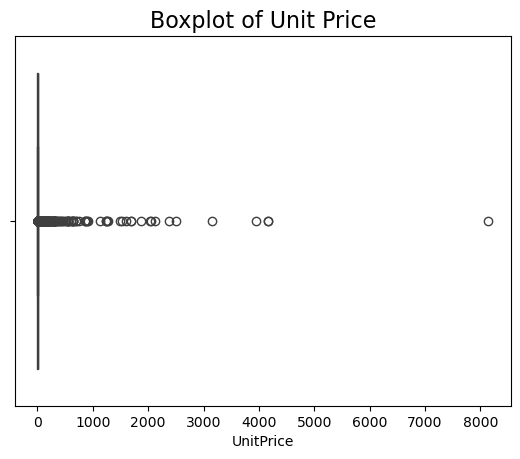

In [15]:
sns.boxplot(data=df,x='UnitPrice')
plt.title('Boxplot of Unit Price',fontsize=16)
plt.show()




In [16]:
df[df['UnitPrice']>1000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
117054,546328,M,Manual,1,2011-03-11 10:19:00,1687.17,14911,EIRE
117055,546329,M,Manual,1,2011-03-11 10:22:00,1687.17,14911,EIRE
144826,548813,M,Manual,1,2011-04-04 13:03:00,2382.92,12744,Singapore
144828,548813,M,Manual,1,2011-04-04 13:03:00,1252.95,12744,Singapore
144829,548820,M,Manual,1,2011-04-04 13:04:00,2053.07,12744,Singapore
145831,548913,M,Manual,1,2011-04-05 09:45:00,1136.30,12669,France
150615,549468,M,Manual,1,2011-04-08 14:27:00,1867.86,17940,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom
200745,554155,M,Manual,1,2011-05-23 11:26:00,1241.98,12757,Portugal
201553,554301,M,Manual,1,2011-05-23 14:46:00,1241.98,12757,Portugal


the extrame high unit price values mostly come from postage and manual fee, these will not be used for the RFM analysis, so they can be removed


In [17]:
non_related_orders=df[(df['StockCode']=='M')|(df['StockCode']=='POST')|(df['StockCode']=='DOT')]
df.drop(non_related_orders.index,inplace=True)
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,391298.000000,391298,391298.000000
mean,13.140709,2011-07-10 19:38:55.997475328,2.890748
min,1.000000,2010-12-01 08:26:00,0.001000
25%,2.000000,2011-04-07 11:16:00,1.250000
50%,6.000000,2011-07-31 12:05:00,1.950000
75%,12.000000,2011-10-20 12:57:00,3.750000
max,80995.000000,2011-12-09 12:50:00,649.500000
std,180.773788,NaN,4.375676


In [18]:
df[df['UnitPrice']<0.01]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,13952,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,15618,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 14:58:00,0.001,16198,United Kingdom
361741,568375,BANK CHARGES,Bank Charges,1,2011-09-26 17:01:00,0.001,13405,United Kingdom


the extrame low values of unit price are normal orders, keep them


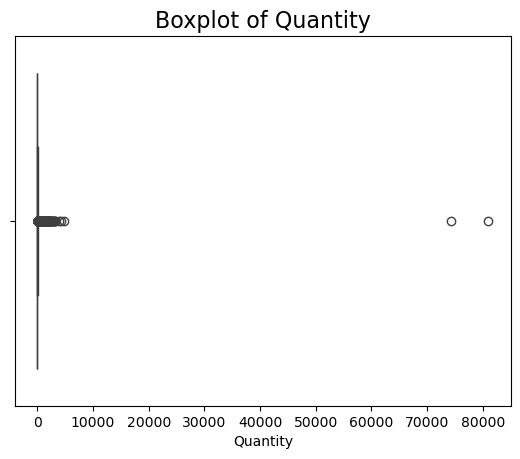

In [19]:
sns.boxplot(data=df,x='Quantity')
plt.title('Boxplot of Quantity',fontsize=16)
plt.show()

In [20]:
df[df['Quantity']>10000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


In [21]:
df.loc[(df['CustomerID']=='12346')& (df['StockCode']==23166)]
df.loc[df['StockCode']==23166]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
186770,552882,23166,MEDIUM CERAMIC TOP STORAGE JAR,96,2011-05-12 10:10:00,1.04,14646,Netherlands
187196,552953,23166,MEDIUM CERAMIC TOP STORAGE JAR,4,2011-05-12 12:11:00,1.25,16745,United Kingdom
187718,553005,23166,MEDIUM CERAMIC TOP STORAGE JAR,5,2011-05-12 16:29:00,1.25,14651,United Kingdom
187868,553009,23166,MEDIUM CERAMIC TOP STORAGE JAR,3,2011-05-12 16:52:00,1.25,13601,United Kingdom
...,...,...,...,...,...,...,...,...
526381,580665,23166,MEDIUM CERAMIC TOP STORAGE JAR,96,2011-12-05 14:06:00,1.04,16684,United Kingdom
531499,580956,23166,MEDIUM CERAMIC TOP STORAGE JAR,1,2011-12-06 14:23:00,1.25,17841,United Kingdom
532826,580997,23166,MEDIUM CERAMIC TOP STORAGE JAR,4,2011-12-06 17:23:00,1.25,15023,United Kingdom
533742,581108,23166,MEDIUM CERAMIC TOP STORAGE JAR,2,2011-12-07 12:16:00,1.25,15984,United Kingdom


In [22]:
df.loc[(df['CustomerID']=='16446')& (df['StockCode']==23843)]
df.loc[df['StockCode']==23843]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


after analyzing the StockCode and CustomerID,the two high quantity orders are considered as outliers, as they are not aligned with normal purchase patterns.


In [23]:
df=df[df['Quantity']<10000]
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,391296.000000,391296,391296.000000
mean,12.744120,2011-07-10 19:39:00.818663936,2.890754
min,1.000000,2010-12-01 08:26:00,0.001000
25%,2.000000,2011-04-07 11:16:00,1.250000
50%,6.000000,2011-07-31 12:05:00,1.950000
75%,12.000000,2011-10-20 12:57:00,3.750000
max,4800.000000,2011-12-09 12:50:00,649.500000
std,42.991524,NaN,4.375686


# Step 3 Create Recency Frequency Monetary (RFM) table


In [24]:
# create revenue column
df['Revenue']=df['UnitPrice']*df['Quantity']


In [25]:
# create rfm table
from datetime import timedelta
max_date=df['InvoiceDate'].max()+timedelta(days=1)
rfm=df.groupby('CustomerID').agg({
 'InvoiceDate':lambda x:(max_date-x.max()).days,
  'InvoiceNo':lambda x:x.count(),
  'Revenue':lambda x:x.sum()}).reset_index()
rfm.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'Revenue': 'MonetaryValue'},inplace=True)
rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12347,2,182,4310.00
1,12348,75,27,1437.24
2,12349,19,72,1457.55
3,12350,310,16,294.40
4,12352,36,77,1385.74


# Step 4 Manage Skewness and Scaling


## Recency, Frequency,MonetaryValue distributions


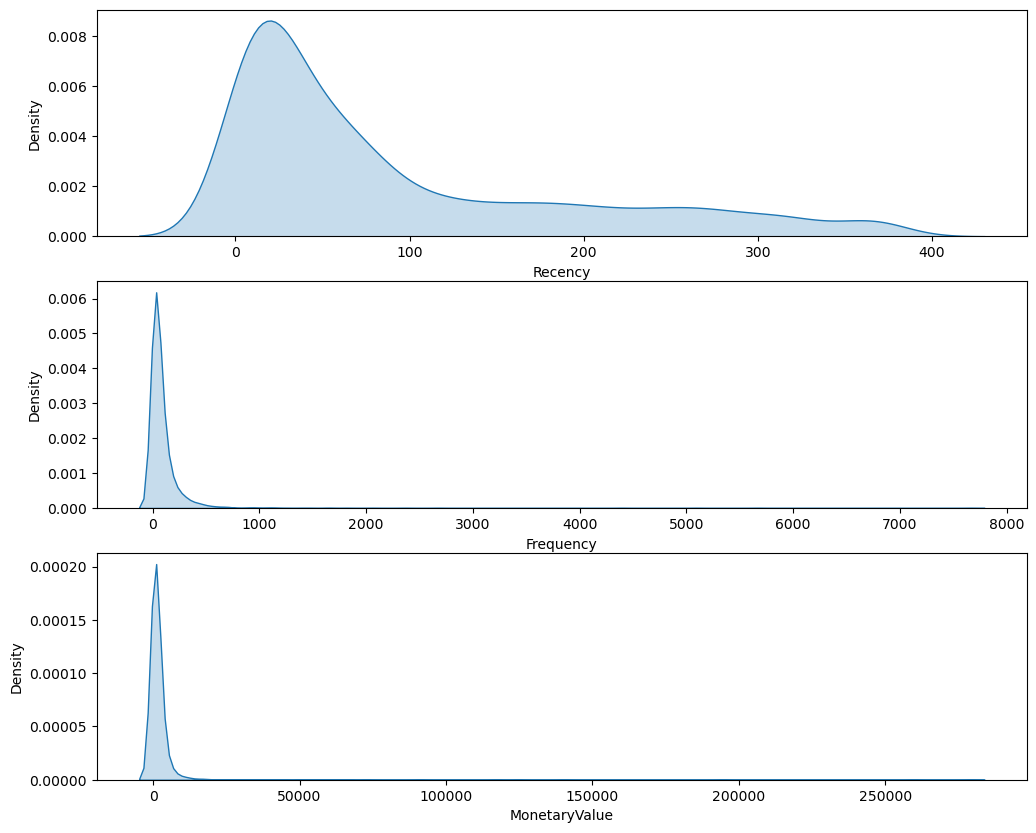

In [26]:
plt.figure(figsize=(12,10))
plt.subplot(3,1,1);sns.kdeplot(data=rfm,x='Recency',shade=True)
plt.subplot(3,1,2);sns.kdeplot(data=rfm,x='Frequency',shade=True)
plt.subplot(3,1,3);sns.kdeplot(data=rfm,x='MonetaryValue',shade=True)
plt.show()

### Analysis:

#### **Recency (Recent Purchase Time):**

**Skewness**: Although this feature shows a certain peak and has less skewness compared to the other two features, it still exhibits some skew.

#### **Frequency (Purchase Frequency):**

**Extreme Skewness**: This feature shows a **strong skew**, where most customers have a low purchase frequency, and only a few customers have an exceptionally high frequency. This distribution may cause K-means clustering to be influenced by a small number of highly frequent customers.

#### **Monetary Value:**

**Extreme Skewness**: This feature exhibits a similar **long-tailed distribution** as Frequency, where a few customers contribute most of the revenue. High-spending customers will disproportionately affect the K-means clustering results.

#### **Transform Skewed Data:**

There are some methods that we can use to manage the skewness:

- log transformation
- square root transformation
- box-cox transformation Note: We can use the transformation if and only if the variable only has positive values


In [27]:
from scipy import stats 
def analyze_skewness(x):
    fig,ax=plt.subplots(2,2,figsize=(5,5))
    sns.kdeplot(rfm[x],ax=ax[0,0])
    sns.kdeplot(np.log(rfm[x]),ax=ax[0,1])
    sns.kdeplot(np.sqrt(rfm[x]),ax=ax[1,0])
    sns.kdeplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.show()
    print(f'log transform: the skew coefficient of {rfm[x].skew().round(2)} to {(np.log(rfm[x].skew()).round(2))}')
    print(f'square root transform: the skew coefficient of {rfm[x].skew().round(2)} to {(np.sqrt(rfm[x].skew()).round(2))}')
    print(f'box-cox transform : The skew coefficient of {rfm[x].skew().round(2)} to  {pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2)}')

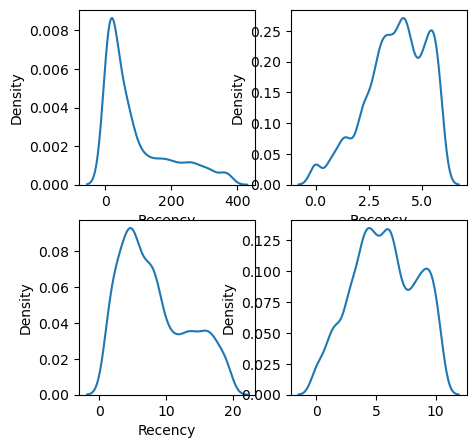

log transform: the skew coefficient of 1.24 to 0.22
square root transform: the skew coefficient of 1.24 to 1.12
box-cox transform : The skew coefficient of 1.24 to  -0.07


In [28]:
analyze_skewness('Recency')

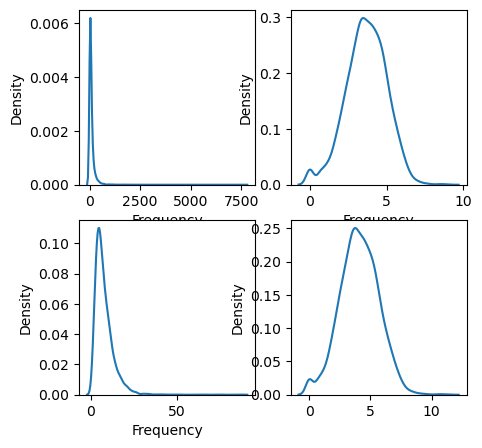

log transform: the skew coefficient of 18.05 to 2.89
square root transform: the skew coefficient of 18.05 to 4.25
box-cox transform : The skew coefficient of 18.05 to  0.0


In [29]:
analyze_skewness('Frequency')

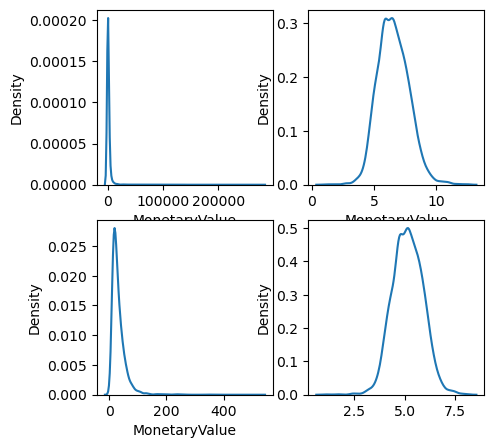

log transform: the skew coefficient of 20.89 to 3.04
square root transform: the skew coefficient of 20.89 to 4.57
box-cox transform : The skew coefficient of 20.89 to  -0.02


In [30]:
analyze_skewness('MonetaryValue')

box-cox can minimize the skewness


In [31]:
rfm_trans=pd.DataFrame()
rfm_trans['Recency']=stats.boxcox(rfm['Recency']) [0]
rfm_trans['Frequency']=stats.boxcox(rfm['Frequency']) [0]
rfm_trans['MonetaryValue']=stats.boxcox(rfm['MonetaryValue']) [0]
rfm_trans.head()

,Recency,Frequency,MonetaryValue
0,0.737062,5.957712,6.231084
1,6.457709,3.588181,5.616776
2,3.854918,4.777427,5.624946
3,9.895048,2.977602,4.636555
4,4.988674,4.861022,5.595491


#### Standardization


In [32]:
from sklearn.preprocessing import StandardScaler
# Initialize the scaler object
scaler = StandardScaler()
# fit and transform data
scaler.fit(rfm_trans)
rfm_standard=scaler.transform(rfm_trans)
print(rfm_standard.mean(axis=0).round(2))
print(rfm_standard.std(axis=0).round(2))


[-0.  0.  0.]
[1. 1. 1.]


# Step 5 Clustering with K-means algorithm


## Determine the Optimal K

To make our clustering reach its maximum performance, we have to determine which hyperparameter fits to the data. To determine which hyperparameter is the best for our model and data, we can use the elbow method to decide.


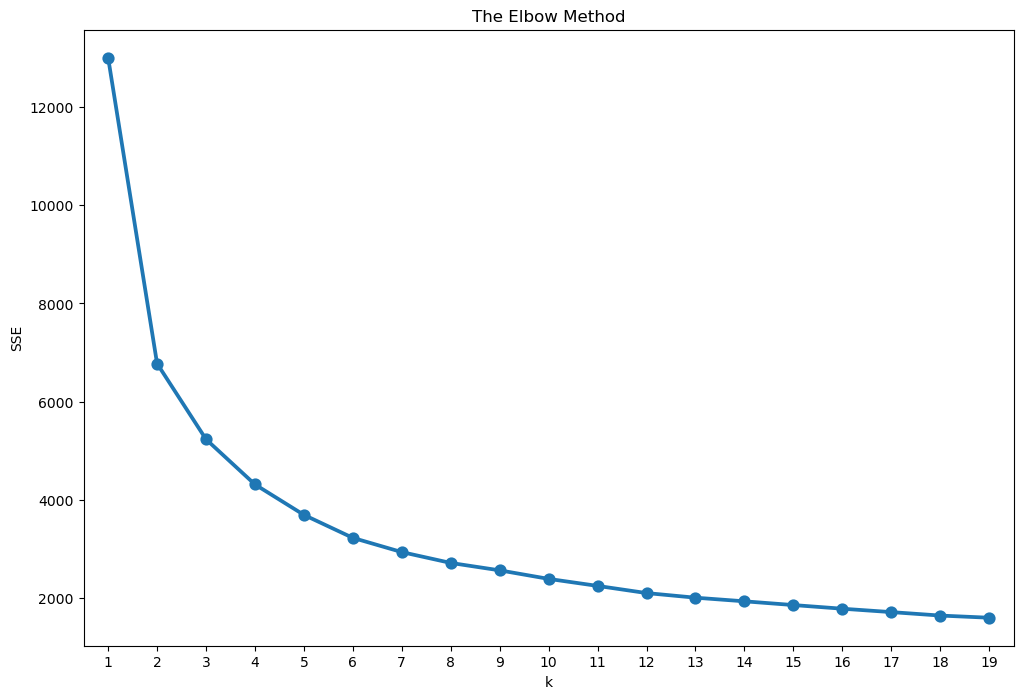

In [33]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
distortions=[]
inertias=[]
mapping1={}
sse={}
for k in range (1,20):
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(rfm_standard)
    distortions.append(sum(np.min(cdist(rfm_standard,kmeans.cluster_centers_,'euclidean'),axis=1))/rfm_standard.shape[0])
    inertias.append(kmeans.inertia_)
    sse[k]=kmeans.inertia_
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),y=list(sse.values()))
plt.show()



The best k value corresponds to the "elbow" in the chart, where the rate of decrease in SSE slows down significantly. k=3 or k=4 are the best k in this case.


### 3 Clusters


In [34]:
model=KMeans(n_clusters=3,random_state=42)
model.fit(rfm_standard)
model.labels_.shape

(4334,)

In [35]:
rfm_standard.shape

(4334, 3)

In [36]:
rfm['Cluster']=model.labels_
rfm.head()
rfm.groupby('Cluster').agg({'Recency':'mean','Frequency':'mean','MonetaryValue':'mean'}).round(1)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,64.3,51.1,916.1
1,20.2,241.5,5613.5
2,193.0,15.2,282.2


### 4 Clusters


In [37]:
model=KMeans(n_clusters=4,random_state=42)
model.fit(rfm_standard)
model.labels_.shape

(4334,)

In [38]:
rfm['Cluster']=model.labels_
rfm.head()
rfm.groupby('Cluster').agg(
    {
     'Recency':'mean','Frequency':'mean','MonetaryValue':'mean'
    }
).round(1)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,28.3,30.4,481.4
1,17.7,230.5,5335.5
2,123.0,62.7,1193.3
3,210.8,12.9,246.1


From the above table, we can compare the distribution of mean values of recency, frequency, and monetary metrics across 3 and 4 cluster data. It seems that we get a more detailed distribution of our customer base using k=4. However, this may not be a very visually appealing method to extract insights.

Another commonly used method to compare the cluster segments is Snakeplots. They are commonly used in marketing research to understand customer perceptions.

Let us build a snake plot for our data with 4 clusters below.


## Cluster Exploration and Visualization


In [39]:
rfm_snake=pd.DataFrame(rfm_standard,columns=['Recency', 'Frequency', 'MonetaryValue'])
rfm_snake['ID']=rfm.index
rfm_snake['Cluster']=model.labels_
rfm_snake.head()


,Recency,Frequency,MonetaryValue,ID,Cluster
0,-1.842590,1.180306,1.397571,0,1
1,0.289900,-0.314024,0.594845,1,2
2,-0.680344,0.435967,0.605520,2,1
3,1.571241,-0.699082,-0.686027,3,3
4,-0.257713,0.488686,0.567031,4,2


In [40]:
rfm_melt=pd.melt(rfm_snake.reset_index(),
                 id_vars=['ID','Cluster'],
                 value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                 var_name='Attribute',
                 value_name='Value')
rfm_melt.head()

,ID,Cluster,Attribute,Value
0,0,1,Recency,-1.842590
1,1,2,Recency,0.289900
2,2,1,Recency,-0.680344
3,3,3,Recency,1.571241
4,4,2,Recency,-0.257713


In [41]:
rfm_group=rfm_melt.groupby('Cluster').agg({'ID':'count'}).reset_index()
rfm_group.rename(columns={'ID':'Count'},inplace=True)
rfm_group['Percent']=((rfm_group['Count']/rfm_group['Count'].sum())*100).round(0)
rfm_group.head()

,Cluster,Count,Percent
0,0,2985,23.0
1,1,3627,28.0
2,2,3309,25.0
3,3,3081,24.0


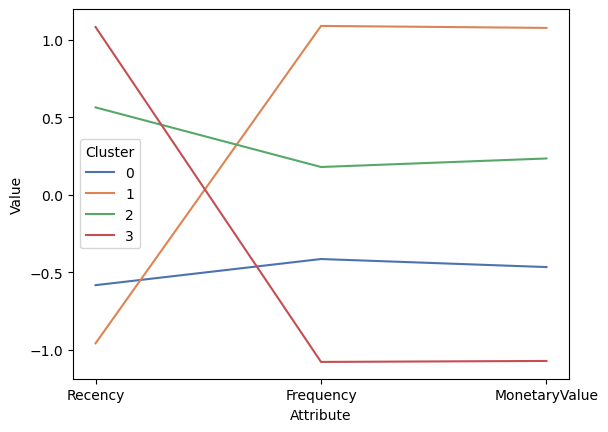

In [48]:
sns.lineplot(data=rfm_melt,x='Attribute',y='Value',hue='Cluster',ci=None,palette='deep')
plt.show()

| Cluster | Type of customers                | %   | RFM Interpretation                                                                                                                                                  |
| ------- | -------------------------------- | --- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 0       | New customers                    | 23% | Customers who transacted recently and have a lower purchase frequency, with a low amount of monetary spending.                                                      |
| 1       | Loyal customers                  | 28% | Most frequent customers with the highest monetary spending amount and transact most recently.                                                                       |
| 2       | At risk customers                | 25% | Customers who made their last transaction a while ago and who made frequent and large purchases in the past.                                                        |
| 3       | Lost customers/churned customers | 24% | Customers who made their last transaction a long time ago, and who have made few purchases. Therefore, it could be the cluster of Lost customers/churned customers. |


# Step 6 Feature Exploratory


## Relationships among Recency Frequency and MonetaryValue


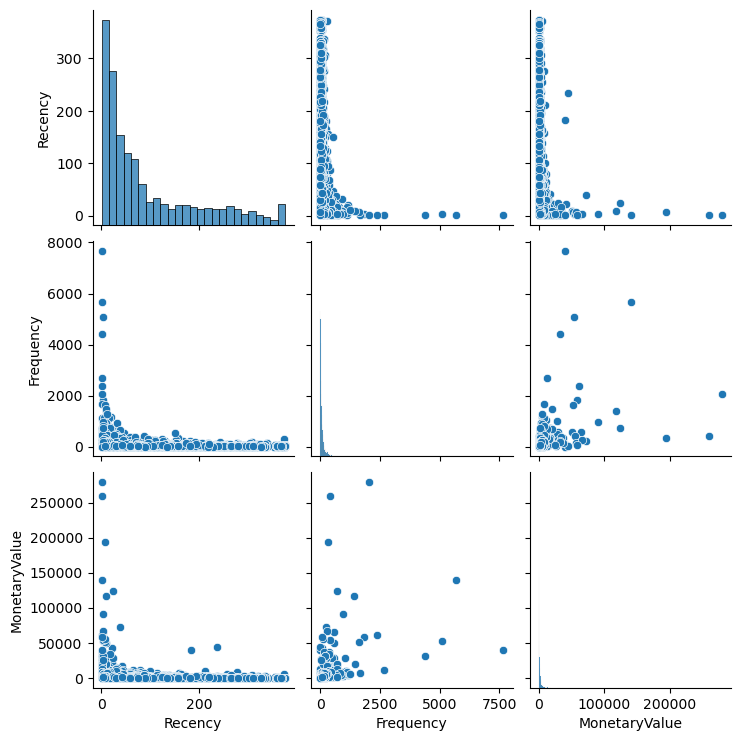

In [58]:
sns.pairplot(rfm[['Recency','Frequency','MonetaryValue']])
plt.show()

A high frequency is found with customers who have a recent purchase recently.

Customers who buy frequently spend less money.

Customers who buy rencently spend less money.


## Feature Importance


We can also use the following method to understand the relative importance of segments in the data. To do this, we will complete the following steps:

- Calculate average values of each cluster
- Calculate average values of population
- Calculate importance score by dividing them and subtracting 1

Score of 0: The cluster is "typical" of the population; there's no difference in average values.

Score > 0: The cluster is "above" the population average for that variable, indicating that this factor is important in that cluster.

Score < 0: The cluster is "below" the population average, indicating that the factor might be less important or even a negative influence.


In [65]:
cluster_avg=rfm.groupby('Cluster')[['Recency','Frequency','MonetaryValue']].mean().round(2)
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,28.26,30.41,481.39
1,17.74,230.45,5335.46
2,123.02,62.69,1193.25
3,210.83,12.93,246.07


In [67]:
total_avg=rfm[['Recency','Frequency','MonetaryValue']].mean().round(2)
total_avg

Recency            92.70
Frequency          90.29
MonetaryValue    1960.87
dtype: float64

In [70]:
importance=(cluster_avg/total_avg-1).round(2)
importance

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.70,-0.66,-0.75
1,-0.81,1.55,1.72
2,0.33,-0.31,-0.39
3,1.27,-0.86,-0.87


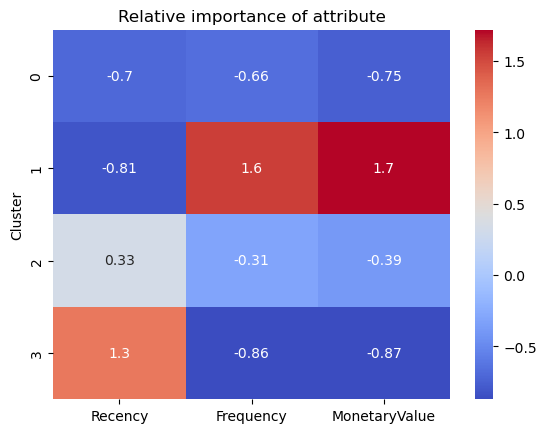

In [79]:
sns.heatmap(importance,annot=True,cmap='coolwarm')
plt.title('Relative importance of attribute')
plt.show()

# Step 7 RFM Segmentation


In [90]:
# Create the quartiles scores
numeric_columns=rfm.select_dtypes(include=['float64','int64']).columns
quantiles = rfm[numeric_columns].quantile(q=[0.2,0.4,0.6,0.8])
quantiles = quantiles.to_dict()
def RScore(x,p,d):
    if x<= d[p][0.2]:
        return 5
    elif x<=d[p][0.4]:
        return 4
    elif x<=d[p][0.6]:
        return 3
    elif x<=d[p][0.8]:
        return 2
    else:
        return 1
def FMScore(x,p,d):
    if x<= d[p][0.2]:
        return 1
    elif x<=d[p][0.4]:
        return 2
    elif x<=d[p][0.6]:
        return 3
    elif x<=d[p][0.8]:
        return 4
    else:
        return 5
rfm['R']=rfm['Recency'].apply(RScore,args=('Recency',quantiles))
rfm['F']=rfm['Frequency'].apply(FMScore,args=('Frequency',quantiles))
rfm['M']=rfm['MonetaryValue'].apply(FMScore,args=('MonetaryValue',quantiles))
rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue,Cluster,R,F,M
0,12347,2,182,4310.00,1,5,5,5
1,12348,75,27,1437.24,2,2,2,4
2,12349,19,72,1457.55,1,4,4,4
3,12350,310,16,294.40,3,1,2,2
4,12352,36,77,1385.74,2,3,4,4


In [92]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x):
    return str(x['R'])+str(x['F'])+str(x['M'])
rfm['RFM_Segment']=rfm.apply(join_rfm,axis=1)
rfm['RFM_Score']=rfm[['R','F','M']].sum(axis=1)
rfm.head()


,CustomerID,Recency,Frequency,MonetaryValue,Cluster,R,F,M,RFM_Segment,RFM_Score
0,12347,2,182,4310.00,1,5,5,5,555,15
1,12348,75,27,1437.24,2,2,2,4,224,8
2,12349,19,72,1457.55,1,4,4,4,444,12
3,12350,310,16,294.40,3,1,2,2,122,5
4,12352,36,77,1385.74,2,3,4,4,344,11


After calculations on the RFM data we can create customer segments that are actionable and easy to understand — like the ones below:

- Champions: Bought recently, buy often and spend the most
- Loyal customers: Buy on a regular basis. Responsive to promotions.
- Potential loyalist: Recent customers with average frequency.
- Recent customers: Bought most recently, but not often.
- Promising: Recent shoppers, but haven’t spent much.
- Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.
- About to sleep: Below average recency and frequency. Will lose them if not reactivated.
- At risk: Some time since they’ve purchased. Need to bring them back!
- Can’t lose them: Used to purchase frequently but haven’t returned for a long time.
- Hibernating: Last purchase was long back and low number of orders. May be lost.


In [93]:
# Create human friendly RFM labels
segt_map = {
    
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At risk',
    r'[1-2]5': 'Can\'t lose them',
    r'3[1-2]': 'About to sleep',
    r'33': 'Need attention',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Promising',
    r'51': 'New customers',
    r'[4-5][2-3]': 'Potential loyalists',
    r'5[4-5]': 'Champions'
}
rfm['Segment']=rfm['R'].map(str)+rfm['F'].map(str)
rfm['Segment']=rfm['Segment'].replace(segt_map,regex=True)
rfm['Score']='Green'
rfm.loc[rfm['RFM_Score']>5,'Score']='Bronze'
rfm.loc[rfm['RFM_Score']>7,'Score'] = 'Silver' 
rfm.loc[rfm['RFM_Score']>9,'Score'] = 'Gold' 
rfm.loc[rfm['RFM_Score']>10,'Score'] = 'Platinum'
rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue,Cluster,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,12347,2,182,4310.00,1,5,5,5,555,15,Champions,Platinum
1,12348,75,27,1437.24,2,2,2,4,224,8,Hibernating,Silver
2,12349,19,72,1457.55,1,4,4,4,444,12,Loyal customers,Platinum
3,12350,310,16,294.40,3,1,2,2,122,5,Hibernating,Green
4,12352,36,77,1385.74,2,3,4,4,344,11,Loyal customers,Platinum


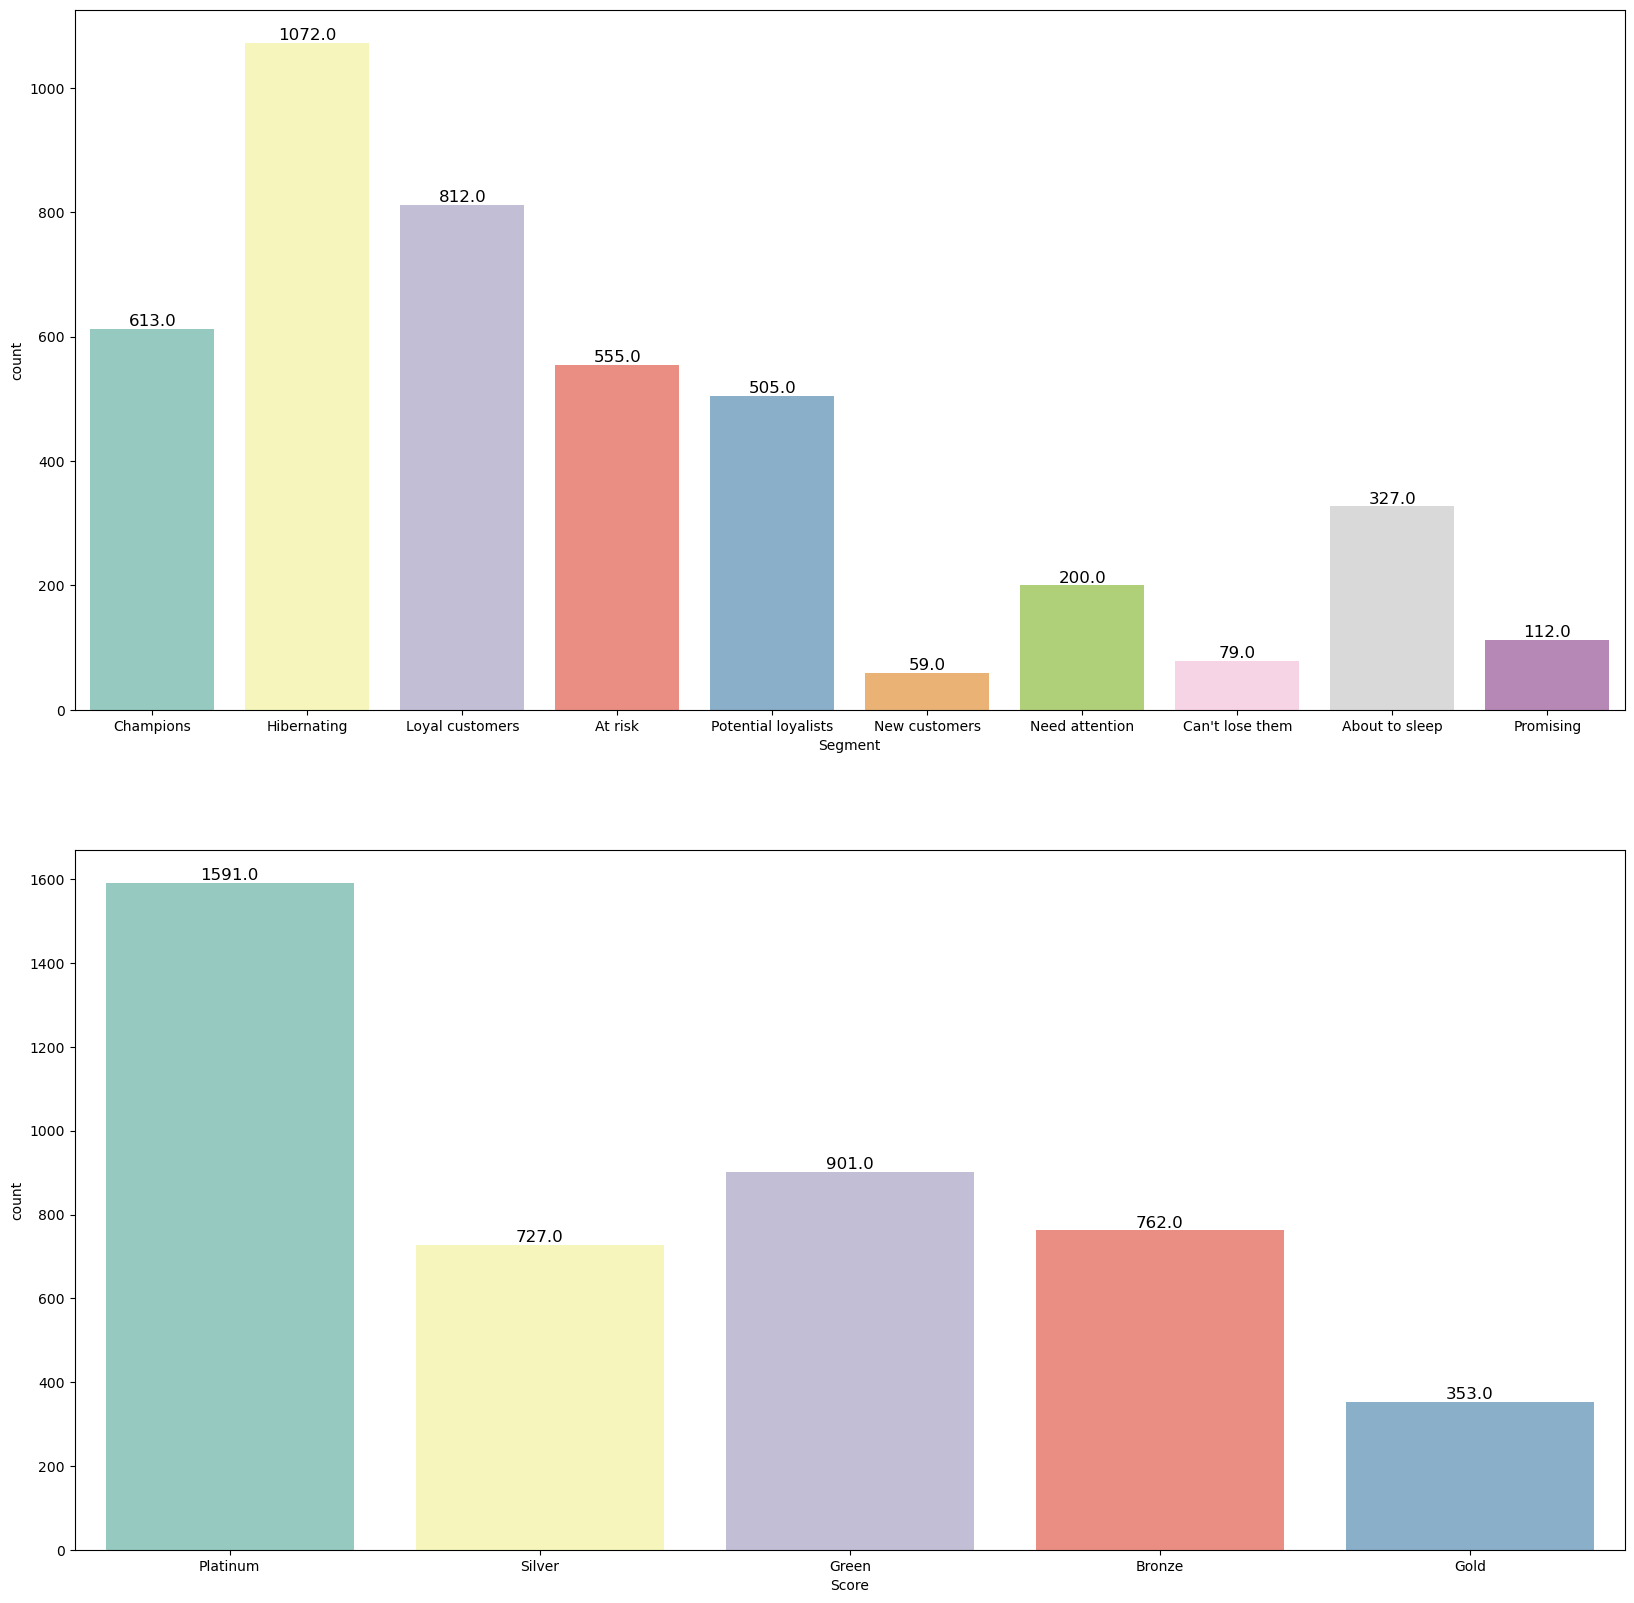

In [115]:
f,ax=plt.subplots(2,1,figsize=(20,20))
sns.countplot(data=rfm,x='Segment',ax=ax[0],palette='Set3')
sns.countplot(data=rfm,x='Score',ax=ax[1],palette='Set3')
for p in ax[0].patches:
    height=p.get_height()
    ax[0].text(
        p.get_x()+p.get_width()/2,
        height+0.1,
        f'{height}',
        ha='center',
        va='bottom',
        fontsize=12
    )
for p in ax[1].patches:
    height=p.get_height()
    ax[1].text(
        p.get_x()+p.get_width()/2,
        height+0.1,
        f'{height}',
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.show()


In [133]:
rfm_group=rfm.groupby(['Cluster','Segment']).agg({'CustomerID':'count'}).reset_index()
rfm_group.rename(columns={'CustomerID':'Count'},inplace=True)
rfm_group['Cluster_Percent']=((rfm_group['Count']/(rfm_group.groupby('Cluster')['Count'].transform('sum')))*100).round(0)
rfm_group


,Cluster,Segment,Count,Cluster_Percent
0,0,About to sleep,210,21.0
1,0,At risk,4,0.0
2,0,Champions,30,3.0
3,0,Hibernating,24,2.0
4,0,Loyal customers,63,6.0
5,0,Need attention,73,7.0
6,0,New customers,57,6.0
7,0,Potential loyalists,435,44.0
8,0,Promising,99,10.0
9,1,About to sleep,1,0.0


# Step 8 Marketing Insights


### Marketing Strategy for Cluster 0: New Customers (23%)

Since **44% of them are Potential Loyalists**, here’s a tailored marketing strategy to engage them and convert them into loyal, high-value customers:

1. **Increasing Frequency**: By offering promotions, loyalty rewards, and reminders.
2. **Increasing Monetary Spending**: Through bundling, upselling, and incentives for larger purchases.
3. **Building Engagement and Trust**: Offering personalized communication, exclusive offers, and social media interaction.
4. **Education**: Through reviews, testimonials, and tutorials to solidify the relationship with the brand.

---

### Marketing Strategy Focus for Cluster 1: Loyal Customers (28%)

Since **48% of loyal customers are Champions and 45% are Loyal Customers**, here is a tailored marketing strategy aimed at enhancing their loyalty and maximizing their lifetime value.

1.  **Consolidating Loyalty**: Ensure customers stay active through exclusive rewards, loyalty programs, and regular appreciation
2.  **Increasing Monetary Spending**: Encourage customers to increase order value through cross-category bundle promotions, personalized recommendations, and customized offers.
3.  **Deepening Customer Engagement**: Strengthen the bond between the brand and customers through regular communication, brand ambassador programs, and VIP events.
4.  **Maintaining High Product and Service Quality**: Improve customer satisfaction by regularly collecting feedback, providing hassle-free after-sales service, and continuously improving product quality.
5.  **Incentivizing Referrals and Word-of-Mouth Marketing**: Leverage loyal customers to expand brand influence through referral reward programs and social media incentives.

---

### Marketing Strategy for Cluster 2: At-Risk Customers (25%)

Since **45% of these customers are at risk of churn**, here is a tailored marketing strategy aimed at **increasing their activity**, **reducing churn**, and converting them into loyal customers. The marketing strategy should focus on:

1. **Enhancing Customer Engagement**: Through personalized incentives and recommendations, encouraging re-engagement.
2. **Offering Special Incentives**: By providing limited-time offers, loyalty reward programs, and added value services to increase purchase frequency.
3. **Strengthening Customer Relationships**: Through direct communication and social media interaction, increasing brand loyalty.
4. **Addressing Potential Issues**: By proactively collecting feedback and providing after-sales support to resolve dissatisfaction.
5. **Educating Customers**: Through product tutorials and brand stories to enhance customer trust and understanding.

---

### Marketing Strategy for Cluster 3: Lost Customers/Churned Customers (24%)

Since **85% of these customers are Hibernating**, here is a tailored marketing strategy aimed at **re-engaging their interest**, reactivating them with appropriate incentives and communication, reducing churn, and converting them into active long-term customers.

1. **Re-Engaging Customer Interest**: By offering personalized incentives and recommendations, attracting dormant customers back.
2. **Offering Attractive Repurchase Incentives**: Through limited-time discounts, first-time returner rewards, and free shipping to stimulate repeat purchases.
3. **Enhancing Customer Experience**: By providing personalized services and hassle-free after-sales to strengthen customer loyalty.
4. **Strengthening Brand Connection**: By rebuilding the relationship through brand events, social media interaction, and thank-you messages.
5. **Educating Customers**: Through product tutorials and brand stories, rebuilding customers' brand perception and trust.
